##  Car Price Project - Algorithms

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pprint
import joblib

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

#Distributions supporting rvs method
from scipy.stats import randint
from scipy.stats import uniform
from skopt.space import Real

#Feature selection
from eli5.sklearn import PermutationImportance
import eli5

#transformers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Model selection
from sklearn.base import clone
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit

#Anomaly detection for outliers.
from sklearn.ensemble import IsolationForest

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import lightgbm as lgb

#Scoring
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

C:\Users\Justin\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Score predictions of fitted model.
def score_algo(model, y, prediction, validation_score, show_ratio=True):
    print('-----------------------------------------------')
    print(f'##### {type(model).__name__} - Prediction Scores:')
    print('-----------------------------------------------')
    print('R^2:', round(r2_score(y, prediction), 4))
    mae = round(mean_absolute_error(y, prediction),2)
    print('MAE:', mae)
    if show_ratio == True:
        print('Ratio to Valid Score:', round(mae/validation_score,3))

In [3]:
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.dialects.postgresql import JSON, JSONB
engine=create_engine("postgresql://postgres@localhost:5432/postgres")

In [4]:
#Read in data tables.  Put quotes around table to make case-sensitive.
vehicle=pd.read_sql('SELECT * from vehicle', engine, index_col='index')
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
vehicle.index.name=None; train.index.name=None; test.index.name=None;

##  Nonlinear Models - LightGBM

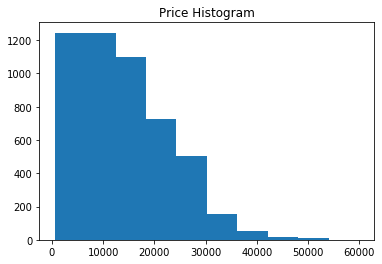

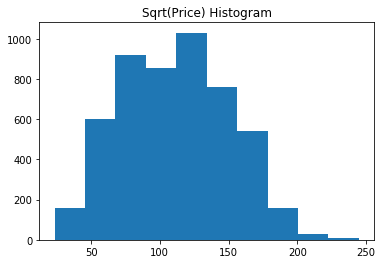

In [5]:
#***************Normalize Price.  Improves heteroskedastic residuals variances.**************

plt.hist(train['Price']); plt.title('Price Histogram'); plt.show();

train['Price'] = np.sqrt(train['Price'])
test['Price'] = np.sqrt(test['Price'])

plt.hist(train['Price']); plt.title('Sqrt(Price) Histogram'); plt.show();

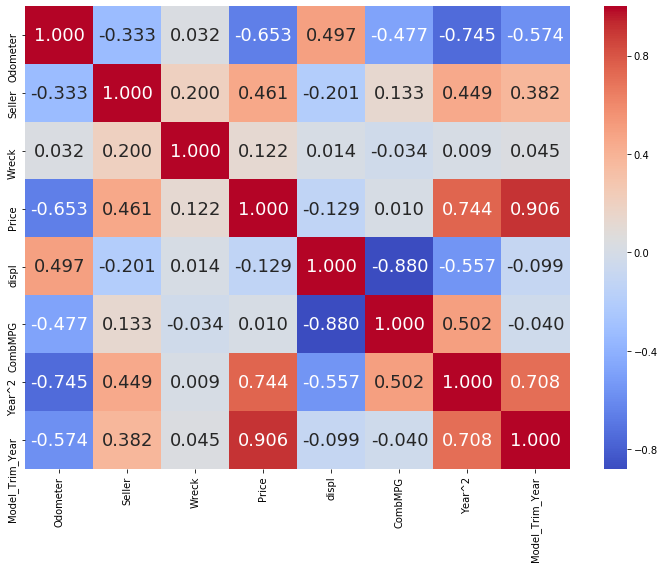

In [6]:
#Show correlation heatmap.  Keeping the collinear features may help prediction, while making the 
#linear regression coefficients less interpretable.
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), cmap='coolwarm', annot=True, annot_kws={"size": 18}, fmt=".3f")
plt.tight_layout()

In [7]:
#Split out Price.
trainX = train.copy()
trainY = trainX.pop('Price')

testX = test.copy()
testY = testX.pop('Price')

### LightGBM model

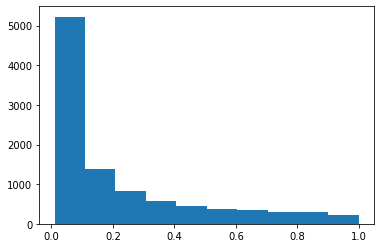

In [8]:
#Log uniform distribution from scikit-optimize
plt.hist(Real(0.01, 1.0, 'log-uniform').rvs(n_samples=10000))
plt.show()

In [9]:
#CREATE LightGBM model with random search.

clf = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', n_jobs=1, silent=1)

param_grid={"learning_rate": Real(0.01, 1.0, 'log-uniform'),
            "n_estimators": randint(100,200),
            "num_leaves": randint(2, 600), 
            "max_depth": randint(0, 40),
            "min_data_in_leaf": randint(10, 200),  #prevents overfittinga
            "max_bin": randint(100,60000),
            "bagging_fraction": Real(0.01, 0.1, 'uniform'),
            "feature_fraction": uniform(0.01, 0.99),
            "subsample_for_bin": randint(100000, 600000),
            "lambda_l2": Real(1e-9, 1000, 'log-uniform'),
            "lambda_l1": Real(1e-9, 1, 'log-uniform'),          
            }

#Instantiate random_search.
lgb_model = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=30, cv=5, n_jobs=-1, refit=True,\
                           scoring='neg_mean_absolute_error', return_train_score=False,random_state=40)

#Tune model with CV. Model will automatically refit on full train with best parameters.
lgb_model.fit(trainX, trainY)

#Tuned model best score.
best_score_std = lgb_model.cv_results_['std_test_score'][lgb_model.best_index_]
print(f'## Grid iters checked: {len(lgb_model.cv_results_["params"])}','\n')
mean_score = np.round(lgb_model.cv_results_["mean_test_score"],2)
print(f'## mean valid scores: {mean_score})', '\n')
print(f'## best valid score: {-lgb_model.best_score_:.2f} +- {best_score_std:.2f}','\n')   
print('## Best parameters:')
best_par = lgb_model.best_params_      
pprint.pprint(best_par)
      
#SCORE model on full data (thanks to refit).
y_test_pred = lgb_model.predict(testX)
print('\nSqrt(test Price):')
score_algo(lgb_model, testY, y_test_pred, -lgb_model.best_score_)
print('\ntest Price:')
score_algo(lgb_model, testY**2, y_test_pred**2, -lgb_model.best_score_, show_ratio=False) 

#Get feature importances using eli5.
perm = PermutationImportance(lgb_model, n_iter=20).fit(testX, testY)
display(eli5.show_weights(perm, feature_names = testX.columns.tolist()))

## Grid iters checked: 30 

## mean valid scores: [ -9.31  -8.96  -8.76 -10.26  -9.16  -9.71  -9.6   -9.13  -9.09 -14.12
 -10.4   -8.87  -9.68 -15.6   -8.98  -9.64  -8.8   -8.99  -8.96  -8.79
  -8.99  -8.8  -11.66  -9.65 -14.08  -8.75  -8.78  -8.89  -8.8   -8.87]) 

## best valid score: 8.75 +- 0.41 

## Best parameters:
{'bagging_fraction': array([0.08644627]),
 'feature_fraction': 0.6784060708074386,
 'lambda_l1': array([1.34453395e-05]),
 'lambda_l2': array([1.35849293e-07]),
 'learning_rate': array([0.08686539]),
 'max_bin': 35280,
 'max_depth': 5,
 'min_data_in_leaf': 78,
 'n_estimators': 158,
 'num_leaves': 481,
 'subsample_for_bin': 206678}

Sqrt(test Price):
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
-----------------------------------------------
R^2: 0.9097
MAE: 8.76
Ratio to Valid Score: 1.001

test Price:
-----------------------------------------------
##### RandomizedSearchCV - Prediction Scores:
--------------------------

Weight,Feature
22.1555 ± 1.6181,Model_Trim_Year
6.4331 ± 0.6582,Odometer
1.7369 ± 0.3792,Year^2
1.6821 ± 0.2722,CombMPG
0.6445 ± 0.1972,Wreck
0.5957 ± 0.2029,Seller
0.4371 ± 0.1134,displ


In [10]:
#Test Price -- MAE stats.
testStat = pd.DataFrame({'true': testY, 'pred':y_test_pred})
testStat['error'] = testStat['true'] - testStat['pred']
testStat['mae'] = abs(testStat['true'] - testStat['pred'])
print('MAE:', testStat['mae'].mean().round(1))
      
testStat = testStat.sort_values(by='mae', ascending=False).round(1)
testStat.describe().round(2)

MAE: 8.8


,true,pred,error,mae
count,563.00,563.00,563.00,563.00
mean,109.67,109.66,0.01,8.76
std,39.02,36.80,11.73,7.79
min,25.50,40.10,-49.00,0.00
25%,77.50,78.95,-6.65,3.10
50%,109.50,107.40,0.00,6.50
75%,139.60,136.85,6.25,12.40
max,221.30,203.00,38.00,49.00


In [11]:
#Reasearch biggest magnitude errors
research = testStat.merge(vehicle.copy(), how='inner', left_index=True, right_index=True)
research.head()

,true,pred,error,mae,URL_Vehicle,Title,Location,Year,Year_in_Title,Odometer,RawMake,Make,Model,Trim,Seller,Wreck,Price,SubLoc,Body,AttribDictionary,ImageDictionary,VehicleID,VIN,displ,CombMPG,DownFlag,Year^2,Model_Trim,Model_Trim_Year
3476,50.0,99.0,-49.0,49.0,https://dallas.craigslist.org/dal/cto/d/duncan...,‘98 Ford F-150 4x4,dallas,1998,None,22500.0,1998 ford f-150,ford,f-150,4x4,owner,clean,2499.0,(Duncanville),"\n ,\n‘98 F150 4x4 automic. exhaust. N...","{'0': '<span><b>1998 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00k0k_93F...,7018488293,None1455,4.6,15.0,None,3992004,f-150_4x4,f-150_4x4_1998
15677,63.2,103.6,-40.4,40.4,https://elpaso.craigslist.org/ctd/d/el-paso-20...,2017 Ford Focus SE Clean title,elpaso,2017,None,NaN,2017 ford focus se,ford,focus,se,dealer,clean,3995.0,(6986 alameda ave),"\n ,\n2017 Ford Focus SE,\nClean title,...",{'0': '<span><b>2017 ford focus se</b></span>'...,{'0': 'https://images.craigslist.org/00K0K_g1h...,7041957899,None6876,2.0,29.0,None,4068289,focus_se,focus_se_2017
70,173.2,135.2,38.0,38.0,https://austin.craigslist.org/ctd/d/lockhart-2...,2011 Ford F-150 4WD SuperCrew 145 SVT Raptor,austin,2011,None,99582.0,2011 Ford F-150,ford,f-150,supercrew,dealer,clean,29998.0,"(Lockhart, TX)","\n ,\n,\n,\naddress: ,phone: ☎ ...","{'0': '<span><b>2011 Ford F-150</b></span>', '...",{'0': 'https://images.craigslist.org/00D0D_9jQ...,7020096851,1FTFW1R64BFB55592,3.7,17.0,None,4044121,f-150_supercrew,f-150_supercrew_2011
16443,191.0,153.0,38.0,38.0,https://houston.craigslist.org/cto/d/houston-f...,Ford F-150 4x4 lariat,houston,2015,None,NaN,2015 ford f-150,ford,f-150,4x4,owner,clean,36500.0,(Memorial city spring branch),"\n ,\n2015 Ford F-150 lariat plus packa...","{'0': '<span><b>2015 ford f-150</b></span>', '...",{'0': 'https://images.craigslist.org/00e0e_jwH...,7038687241,None7269,3.5,19.5,None,4060225,f-150_4x4,f-150_4x4_2015
5812,103.9,66.3,37.7,37.7,https://houston.craigslist.org/ctd/d/alvin-200...,2003 FORD FX-4-$2000.00 DOWN DRIVE OUT-NO CRED...,houston,2003,None,205098.0,2003 2003 FORD F-150 SUPER CREW FX-4,ford,f-150,super,dealer,clean,10800.0,(ALVIN),"\n ,\n= = FALL SAVINGS EVENT= = =YOU MU...",{'0': '<span><b>2003 2003 FORD F-150 SUPER CRE...,{'0': 'https://images.craigslist.org/00e0e_1gu...,7015685808,1FTRW08L93KD68139,5.0,15.0,down,4012009,f-150_super,f-150_super_2003


#### Residuals Plot Functions

In [12]:
# Residuals helper functions
def plot_residuals(predicted, true):
    '''
    Plots predicted vs error.  Error = true - predicted.  Marks
    three standard deviation error from mean with orange bars.  
    Plots error histogram.  Plots regression of predicted vs true.
    Returns indices of 3 sigma anomalies.
    '''
    anomaly_locs = []
    error = true - predicted
    print('error count:', len(error), '| error avg:', round(error.mean(),1), '| high pred percent:', round(100*len(error[error<0])/len(error),1), '| low pred percent:', round(100*len(error[error>=0])/len(error),1), )
    mean = np.mean(error)
    three_std = 3* np.std(error)
    upper_lim = mean + three_std; lower_lim = mean - three_std;
    sns.set(font_scale=1.3)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(9,27))
    sns.scatterplot(x=predicted, y=error, ax=ax1, color='black')    
    ax1.set_title('Scatterplot: Predicted vs Error')
    ax1.set_xlabel('Predicted'); ax1.set_ylabel('Error - True less Predicted');
    ax1.axhline(y=0, color='g', ls='--', alpha=0.8)
    ax1.axhline(y=upper_lim, color='orange', ls='--', alpha=0.8)
    ax1.axhline(y=lower_lim, color='orange', ls='--', alpha=0.8)
    
    for elem in range(0, predicted.shape[0]):  #add iloc for error outside limits. 's=' is the text string.
        x_val = predicted[elem]     #assume predicted is numpy.ndarray
        y_val = error.values[elem]  #assume error is Series
        label_str = str(true.iloc[elem:elem+1].index[0])  #loc
        if (y_val > upper_lim or y_val < lower_lim):
            anomaly_locs.append(true.iloc[elem:elem+1].index[0])
            ax1.text(x=x_val+.05, y=y_val-.04, s=label_str, horizontalalignment = 'left', size=14, color='r')
    
    sns.distplot(error, ax=ax2, kde=True)
    ax2.set_title('Histogram: Error - True Less Predicted')
    ax2.set_xlabel('Error'); ax2.set_ylabel('Frequency');
    ax2.axvline(x=0, color='black', ls='--', alpha=0.8)
    
    sns.regplot(x=predicted, y=true, ax=ax3, color='black', marker='.', ci=None)
    ax3.set_title('Linear Regression Plot: Predicted vs True')
    ax3.set_xlabel('Predicted'); ax3.set_ylabel('True');
    return anomaly_locs

def plot_normal_probability(predicted, true):
    error = true - predicted
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    stats.probplot(error, dist='norm', plot=ax)
    ax.set_title('Residuals Error - Fit to Normal Distribution')
    ax.set_xlabel('Theoretical Quantiles'); ax.set_ylabel('Ordered Values');

error count: 5060 | error avg: 0.0 | high pred percent: 50.6 | low pred percent: 49.4


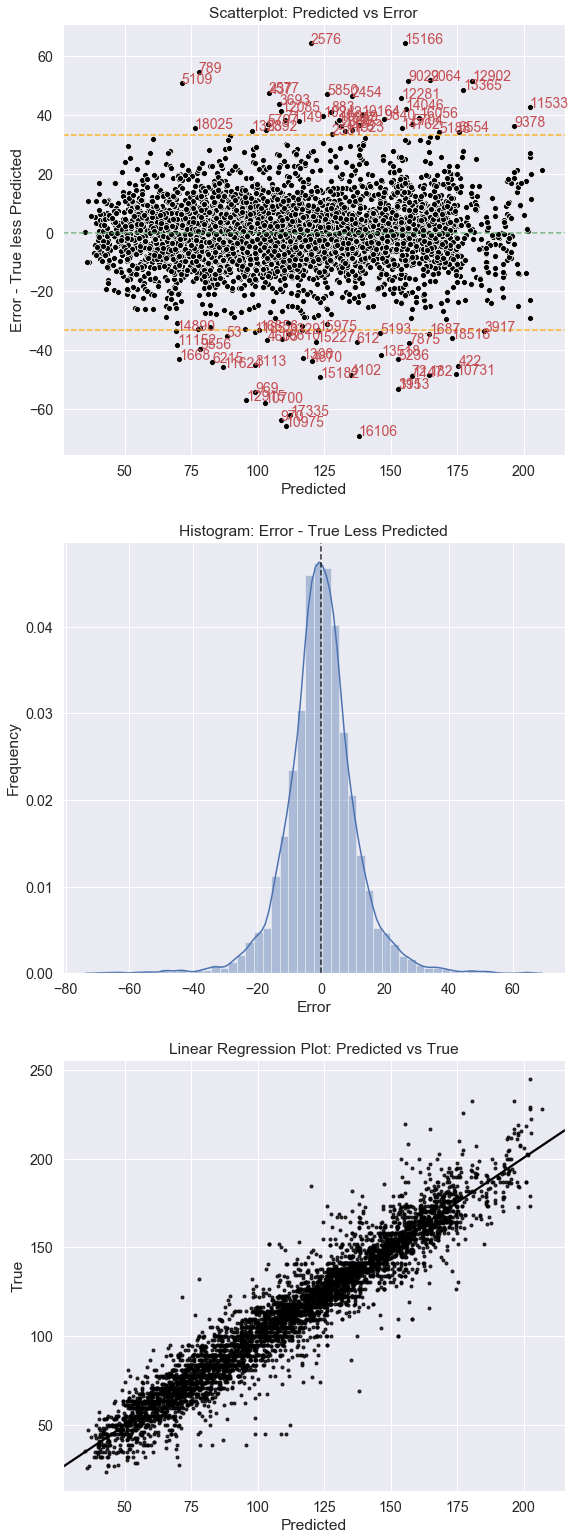

In [13]:
#LightGBM - Plot train residuals.
y_trn_pred = lgb_model.predict(trainX)
anomal = plot_residuals(predicted=y_trn_pred, true=trainY)

error count: 563 | error avg: 0.0 | high pred percent: 49.6 | low pred percent: 50.4


[15677, 70, 5812, 2258, 16443, 3476, 10794]

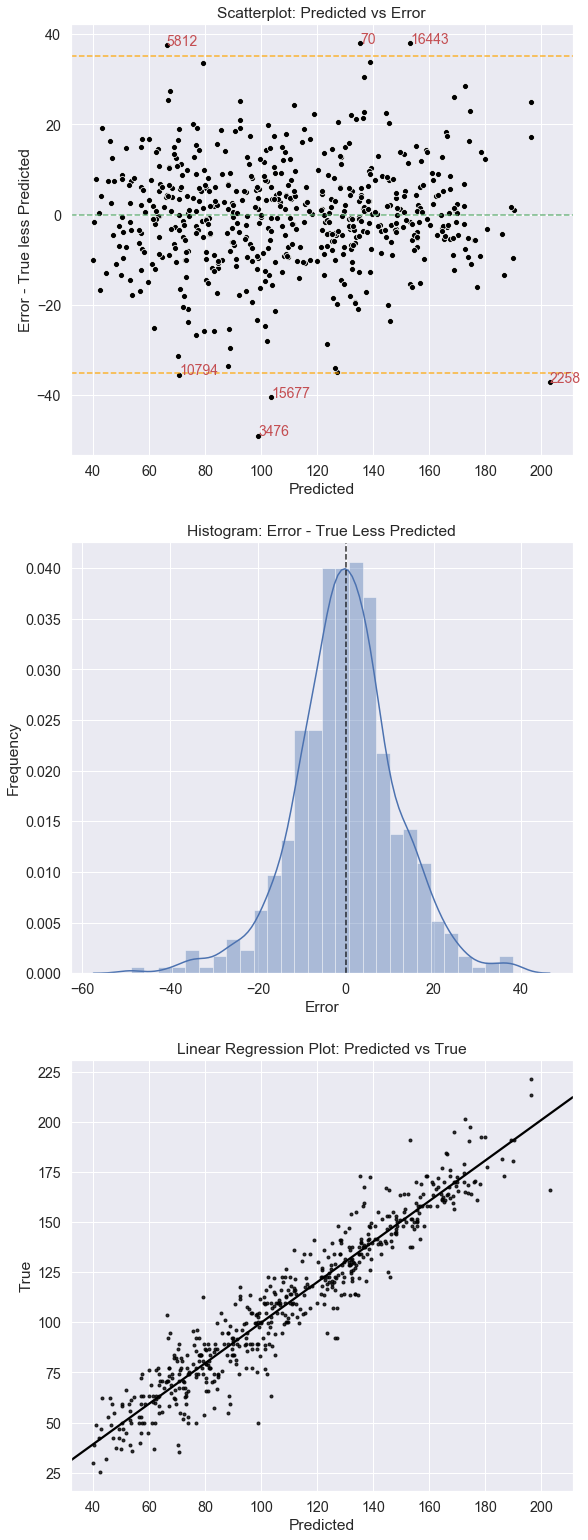

In [14]:
#LightGBM - Plot test residuals.
plot_residuals(predicted=y_test_pred, true=testY)

## Linear Regression Model

In [15]:
train=pd.read_sql('SELECT * from "trainClean"', engine, index_col='index')
test=pd.read_sql('SELECT * from "testClean"', engine, index_col='index')
train.index.name=None; test.index.name=None; 
train.shape

(5060, 8)

In [16]:
train.head(1)

,Odometer,Seller,Wreck,Price,displ,CombMPG,Year^2,Model_Trim_Year
6460,64510.0,16557.575275,14182.685976,19499.0,3.5,19.5,4060225.0,18328.954545


In [17]:
#Split out Price
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

# #Normalize Price
trainY = np.sqrt(trainY)
testY = np.sqrt(testY)

In [18]:
def scale_num_df(train_df, test_df, numer_cols, scaler):
    '''Scale train.  Transform test with the same scaling stats.
    Returns scaled train and scaled test.'''
    from sklearn.preprocessing import RobustScaler
    scaled_trn_num_df = pd.DataFrame(scaler.fit_transform(train_df[numer_cols]))
    scaled_trn_num_df.index=train_df.index
    scaled_trn_num_df.columns=train_df[numer_cols].columns
    
    scaled_tst_num_df = pd.DataFrame(scaler.transform(test_df[numer_cols]))
    scaled_tst_num_df.index=test_df.index
    scaled_tst_num_df.columns=test_df[numer_cols].columns
    return scaled_trn_num_df, scaled_tst_num_df

#Standard scale so regression coefficient units are the same.
trainX, testX = scale_num_df(trainX.copy(), testX.copy(), trainX.columns, StandardScaler())

In [19]:
trainX.describe().round(2)

,Odometer,Seller,Wreck,displ,CombMPG,Year^2,Model_Trim_Year
count,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00,5060.00
mean,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.76,-1.44,-5.73,-1.81,-2.07,-3.42,-1.55
25%,-0.82,-1.44,0.23,-0.95,-0.71,-0.62,-0.84
50%,-0.06,0.69,0.23,0.01,-0.27,0.18,-0.15
75%,0.70,0.69,0.23,0.77,0.40,0.79,0.65
max,4.85,0.69,1.43,1.89,3.05,1.59,4.48


## `Tune Linear Models with Cross Validation`

In [20]:
def train_and_valid(what_model, num_folds, X, y):
    fold_mae=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):
        #Clone is a model copy not yet fit on the data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns
        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_mae.append(round(mean_absolute_error(valid_y, valid_pred), 2))
        
    print(f'***Tune {type(what_model).__name__}***\n## Fold MAE:', fold_mae)
    avg_mae = round(np.mean(fold_mae),1)
    print('## Avg MAE:', avg_mae,'+-', round(np.std(fold_mae),1))
    print('## Clone R^2:', round(clone_model.score(X,y),3))
    return clone_model, avg_mae

In [21]:
#Linear regression finds the coeficcients that minimize the residual sum of squares.
lr=LinearRegression(fit_intercept=True)
lr_clone, avg_mae=train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)

***Tune LinearRegression***
## Fold MAE: [9.79, 10.1, 9.72, 10.0, 9.5, 9.9, 9.69, 9.29, 9.5, 9.4]
## Avg MAE: 9.7 +- 0.3
## Clone R^2: 0.882


In [22]:
#Get LinearRegression feature importances.  Note: collinearity distorts feature importances.
perm = PermutationImportance(lr_clone,n_iter=20).fit(trainX, trainY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.6416 ± 0.0152,Model_Trim_Year
0.1311 ± 0.0055,Year^2
0.0956 ± 0.0041,Odometer
0.0539 ± 0.0031,CombMPG
0.0130 ± 0.0011,Wreck
0.0110 ± 0.0012,Seller
0.0044 ± 0.0010,displ


## `Linear Model Predictions - Fit on 100% of train`

In [23]:
linregr=LinearRegression(fit_intercept=True)  #no scaling required for closed-form solution, only for coefficient
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
print('Sqrt(Price):')
score_algo(linregr, testY, y_pred_linregr, avg_mae)

#Score original Price
print('\nPrice:')
score_algo(linregr, testY**2, y_pred_linregr**2, avg_mae, show_ratio=False)

Sqrt(Price):
-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8789
MAE: 10.14
Ratio to Valid Score: 1.045

Price:
-----------------------------------------------
##### LinearRegression - Prediction Scores:
-----------------------------------------------
R^2: 0.8803
MAE: 2205.73


In [24]:
#Linear Regression Coefficients. Each feature has the same scale: value per unit of standard deviation.
pd.DataFrame({'feature': trainX.columns, 'coef' : np.round(linregr.coef_,2)})

,feature,coef
0,Odometer,-8.46
1,Seller,2.80
2,Wreck,3.13
3,displ,1.76
4,CombMPG,-6.45
5,Year^2,9.94
6,Model_Trim_Year,21.86


error count: 563 | error avg: -0.5 | high pred percent: 51.2 | low pred percent: 48.8


[15677, 70, 16443, 1097, 8181, 3476, 10794, 332]

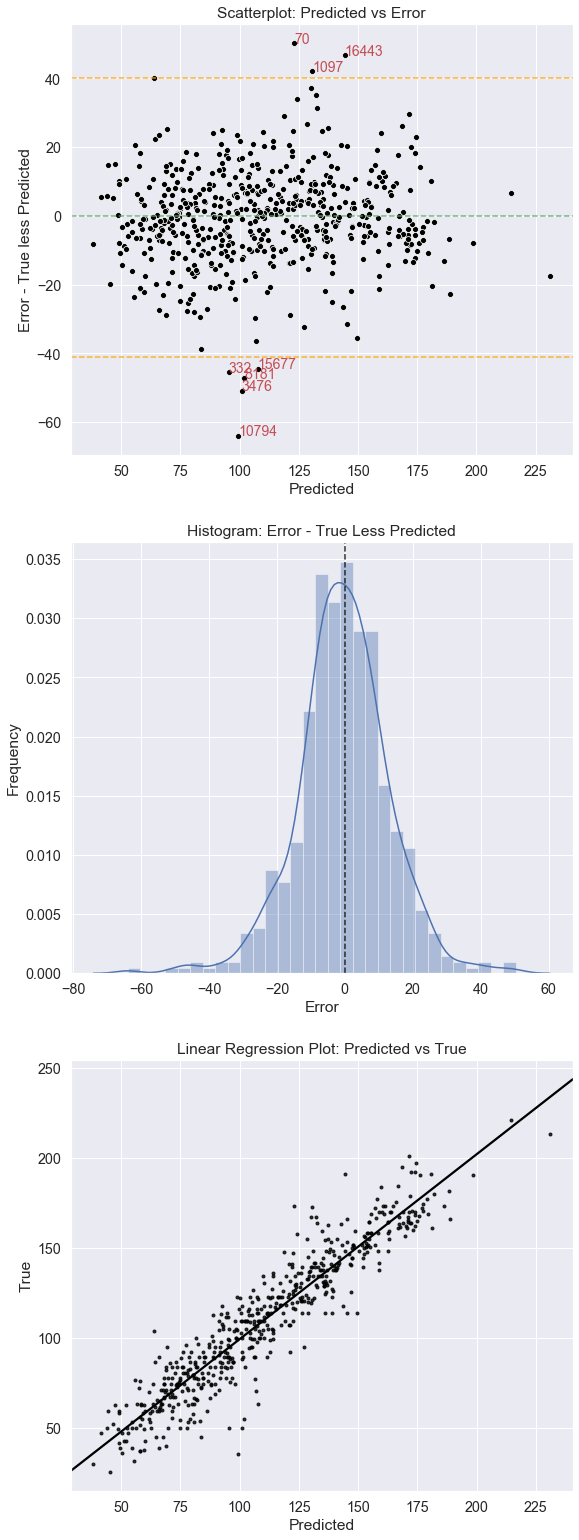

In [25]:
#Get test residuals.  A non-normal error means errors are not random.  Are there outliers?  Try transforming features
#to make them closer to normally distributed.  We will not go down this path today as we have a more accurate LightGBM
#model with better-looking residuals.  LightGBM can model non-linear relationships, in contrast to a linear regression.
plot_residuals(predicted=y_pred_linregr, true=testY)

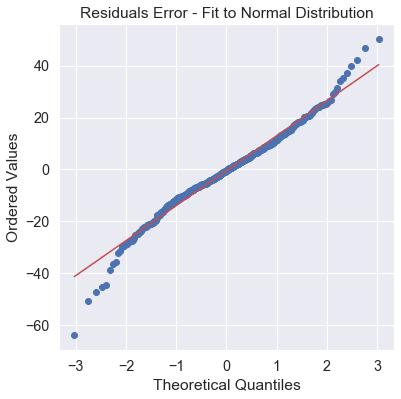

In [26]:
#Normal probability plot for linear model.
plot_normal_probability(predicted=y_pred_linregr, true=testY)